In [2]:
import sys
import sqlite3
import pandas as pd
pd.options.mode.chained_assignment = None
from pandas import DataFrame
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

def get_connexion():
    conn = sqlite3.connect('../bdebPannesElectriques.dbf')
    return conn

def fermer_connexion(con):
    con.close()

# EXTRACT FROM SQL AND LOAD TO PANDAS

In [3]:
# Selection de la table
requete = ("""
            select 
                date_heure_debut as date_heure, nom as region,  interruption, clients_prive, clients_total, 
                 condition, pression, temperature, point_de_rosee, humidite, vent_direction, vent_velocite, visibilite                
            from scrapping s
            inner join panne p on p.id_scrapping = s.id
            inner join region r on p.id_region = r.id
            inner join meteo m on m.id_region = p.id_region and m.id_scrapping = p.id_scrapping
            where s.id > 3 
            """)
conn = get_connexion()
curseur = conn.cursor()
curseur.execute(requete)
#print(field_names)

df = DataFrame(curseur.fetchall())
df.columns = [i[0] for i in curseur.description]

fermer_connexion(get_connexion())

df

,date_heure,region,interruption,clients_prive,clients_total,condition,pression,temperature,point_de_rosee,humidite,vent_direction,vent_velocite,visibilite
0,2024-06-05 08:00:04.244482,Québec (V),0,0,321987,Généralement nuageux,101.3,15.8,13.3,85.0,ENE,15.0,48.0
1,2024-06-05 08:00:04.244482,Drummondville (V),0,0,46251,,101.2,16.8,15.6,93.0,,calme,
2,2024-06-05 08:00:04.244482,Granby (V),0,0,39883,,101.2,21.1,16.6,76.0,,calme,
3,2024-06-05 08:00:04.244482,Sherbrooke (V),0,0,8856,Généralement ensoleillé,101.3,16.9,14.1,84.0,E,5.0,16.0
4,2024-06-05 08:00:04.244482,Saint-Jérôme (V),0,0,45211,Généralement nuageux,101.2,18.5,14.4,77.0,NE,7.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,2024-06-29 22:54:53.720734,Trois-Rivières (V),0,0,83628,Pluie faible,100.7,19.9,19.9,100.0,SO,21.0,8.0
5570,2024-06-29 22:54:53.720734,Montréal (V),1,434,995903,Nuageux,100.8,22.0,20.9,94.0,SO,12.0,24.0
5571,2024-06-29 22:54:53.720734,Saint-Jean-sur-Richelieu (V),0,0,51070,,,20.0,19.3,96.0,S,16.0,
5572,2024-06-29 22:54:53.720734,Gatineau (V),1,8,146504,,100.8,22.1,20.8,92.0,SSO,6.0,


# TRANSFORMATION

In [4]:
df.date_heure = pd.to_datetime(df['date_heure']).dt.floor('h')
df.region = df['region'].str.replace(' (V)','')

df["vent_velocite"] = np.where(df["vent_velocite"] == "calme", 0.0, df["vent_velocite"])

df["vent_velocite"] = np.where(df["vent_velocite"] == "calme" , 0.0, df["vent_velocite"])
df["vent_velocite"] = np.where(df["vent_velocite"] == "" , 0.0, df["vent_velocite"])


# Vérification des problèmes d'exécution

In [12]:
import datetime

def generate_dates(start_date):
  today = datetime.datetime.today() # Change to datetime.datetime
  yesterday = today - datetime.timedelta(days=1)
  date_list = []
  current_date = start_date
  while current_date <= today:
    date_list.append(current_date)
    current_date += datetime.timedelta(hours=1)
  return date_list

start_date = datetime.datetime(2024, 6, 5, 8, 0, 0)
date_list = generate_dates(start_date)
dates_series = pd.Series(date_list)

printmd('Nombre d\'exécutions de scripts')
print(len(df['date_heure'].unique()))

not_in_df = dates_series[~dates_series.isin(df['date_heure'])]
printmd('Dates/heure auxquelles le script n\'a pas fonctionné')
print(not_in_df)

df_group_by_date_heure = df.groupby('date_heure').count().reset_index();
df_scrapping_incomplet = df_group_by_date_heure[df_group_by_date_heure['region'] < 10]
printmd('Dates/heure où le script a été partiellement exécuté ( < 10 region)')
print(df_scrapping_incomplet[['date_heure', 'region']])


Nombre d'exécutions de scripts

562


Dates/heure auxquelles le script n'a pas fonctionné

232   2024-06-15 00:00:00
233   2024-06-15 01:00:00
234   2024-06-15 02:00:00
235   2024-06-15 03:00:00
236   2024-06-15 04:00:00
305   2024-06-18 01:00:00
539   2024-06-27 19:00:00
561   2024-06-28 17:00:00
563   2024-06-28 19:00:00
564   2024-06-28 20:00:00
566   2024-06-28 22:00:00
567   2024-06-28 23:00:00
568   2024-06-29 00:00:00
569   2024-06-29 01:00:00
570   2024-06-29 02:00:00
571   2024-06-29 03:00:00
572   2024-06-29 04:00:00
573   2024-06-29 05:00:00
574   2024-06-29 06:00:00
576   2024-06-29 08:00:00
577   2024-06-29 09:00:00
582   2024-06-29 14:00:00
583   2024-06-29 15:00:00
584   2024-06-29 16:00:00
585   2024-06-29 17:00:00
586   2024-06-29 18:00:00
587   2024-06-29 19:00:00
588   2024-06-29 20:00:00
589   2024-06-29 21:00:00
591   2024-06-29 23:00:00
dtype: datetime64[ns]


Dates/heure où le script a été partiellement exécuté ( < 10 region)

             date_heure  region
292 2024-06-17 17:00:00       4
296 2024-06-17 21:00:00       7
298 2024-06-17 23:00:00       7
300 2024-06-18 02:00:00       2
303 2024-06-18 05:00:00       3
305 2024-06-18 07:00:00       7
306 2024-06-18 08:00:00       9
307 2024-06-18 09:00:00       1
310 2024-06-18 12:00:00       4


# Selection de la ville de Montréal

In [6]:
df_montreal = df[df['region']=='Montréal']
df_montreal = df_montreal.set_index('date_heure')
pd.set_option('display.max_rows', None, 'display.max_columns', None)
df_montreal

,region,interruption,clients_prive,clients_total,condition,pression,temperature,point_de_rosee,humidite,vent_direction,vent_velocite,visibilite
date_heure,,,,,,,,,,,,
2024-06-05 08:00:00,Montréal,6,314,995474,Généralement nuageux,101.2,19.9,15.6,76.0,NNE,9.0,24.0
2024-06-05 09:00:00,Montréal,11,728,995474,Partiellement nuageux,101.2,20.2,15.3,73.0,NE,9.0,24.0
2024-06-05 10:00:00,Montréal,13,887,995474,Partiellement nuageux,101.1,22.3,16.1,68.0,ENE,5.0,24.0
2024-06-05 11:00:00,Montréal,11,798,995474,Généralement nuageux,101.1,24.7,16.9,62.0,SSE,4.0,24.0
2024-06-05 12:00:00,Montréal,11,549,995474,Généralement nuageux,101.0,26.9,15.5,50.0,SSO,7.0,24.0
2024-06-05 13:00:00,Montréal,12,623,995474,Généralement nuageux,101.0,28.1,16.4,49.0,SSE,8.0,24.0
2024-06-05 14:00:00,Montréal,10,1640,995474,Généralement nuageux,100.9,29.6,16.2,44.0,SSO,10.0,24.0
2024-06-05 15:00:00,Montréal,9,1358,995474,Partiellement nuageux,100.8,29.1,17.8,51.0,SE,14.0,24.0
2024-06-05 16:00:00,Montréal,5,73,995474,Partiellement nuageux,100.7,30.0,16.5,44.0,ESE,13.0,24.0


# Graphiques des pannes, de la température et du vent pour chaque ville

In [7]:
def show_graph_bar(x,y, title):   
   
    plt.figure(figsize=(10,5))
    
    for index, value in enumerate(y):
        plt.text(index, value, str(round(value, 2)), rotation = 30, 
         rotation_mode = 'anchor')

    plt.title(title)
    plt.xticks(x)
    plt.bar(x, y)
    plt.show()

def graphs_par_ville(ville):
    printmd(f"# {ville}")
    df_ville = df[df['region']==ville]
    df_ville = df_ville.set_index('date_heure')
    df_ville.head()
    figure, axis = plt.subplots(3, 1,  figsize=(10,15)) 
    
    plt.xticks(rotation=90)
    
    axis[0].plot(df_ville.index, df_ville['interruption'], color='r') 
    axis[0].set_title("Interruptions") 
    axis[0].set(xlabel="Date", ylabel="Interruptions")
    
    axis[1].plot(df_ville.index, df_ville['temperature'], color='g') 
    axis[1].set_title("Temperature") 
    axis[1].set(xlabel="Date", ylabel="Temperature C")
    
    axis[2].plot(df_ville.index, df_ville['vent_velocite'], color='b') 
    axis[2].set_title("Vent") 
    axis[2].set(xlabel="Date", ylabel="Vent Km/h") 
    
    for ax in axis.flatten():
        plt.sca(ax)
        plt.xticks(rotation = 45)
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()

    df_ville_heure = df[df['region']==ville]
    df_ville_heure['heure'] = df_ville_heure['date_heure'].dt.hour
    
    #group by heure
    df_ville_group_heure = df_ville_heure.groupby('heure')[['interruption', 'clients_prive']].mean()

    show_graph_bar(df_ville_group_heure.index, df_ville_group_heure['interruption'], 'Interruptions')
    show_graph_bar(df_ville_group_heure.index, df_ville_group_heure['clients_prive'], 'Clients privés')

# Québec

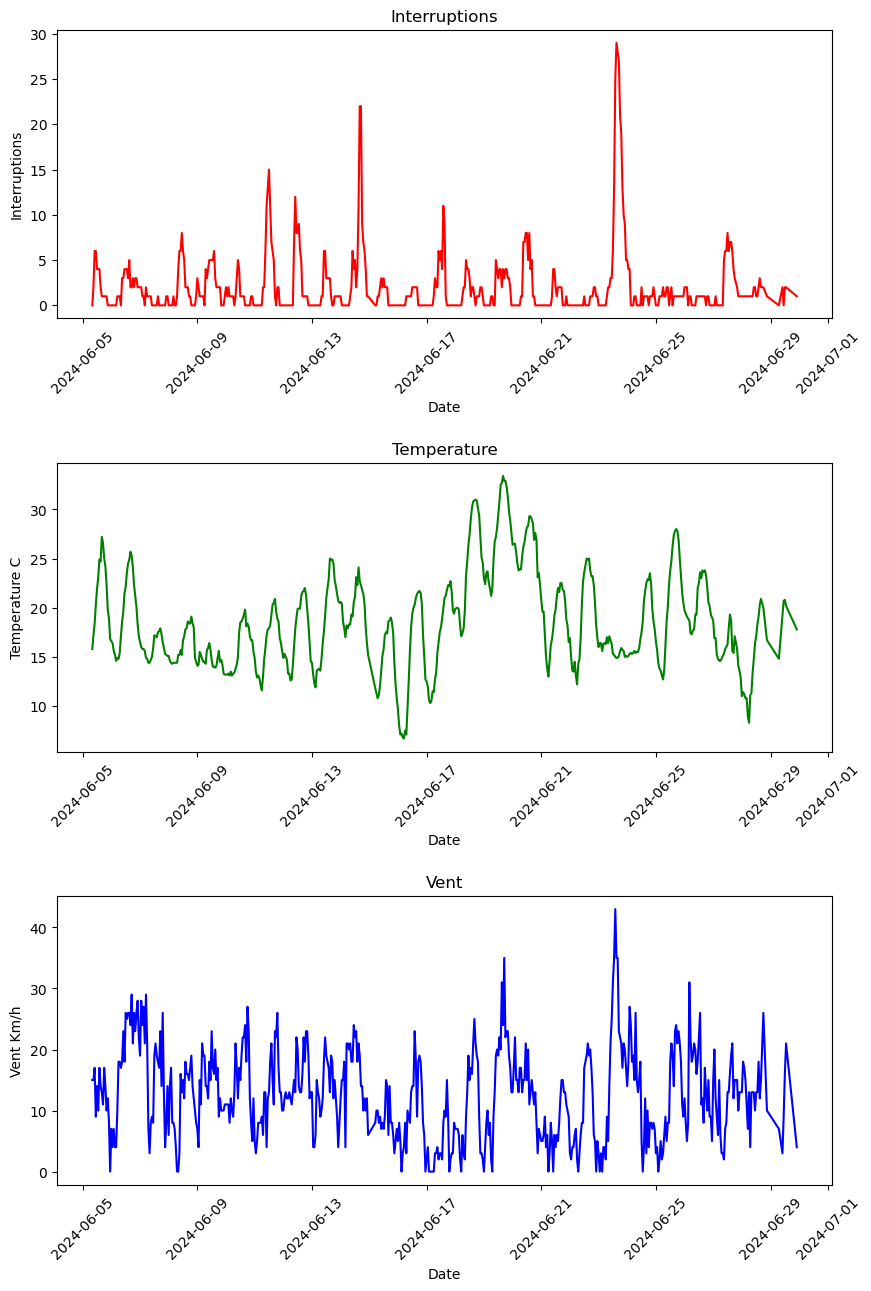

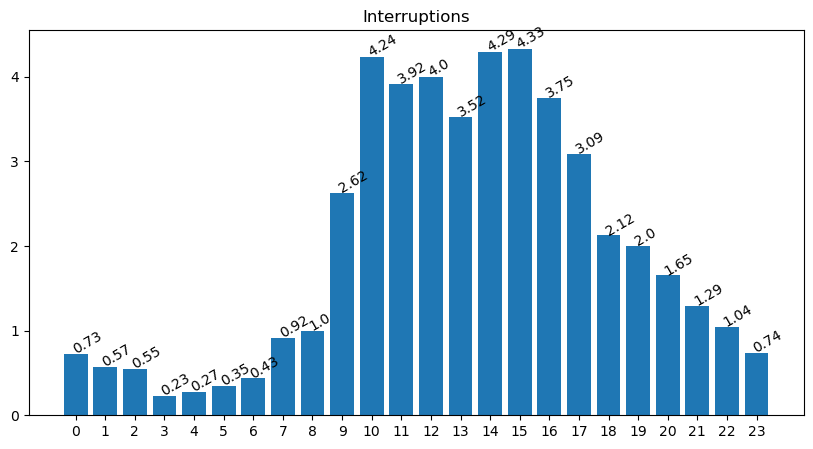

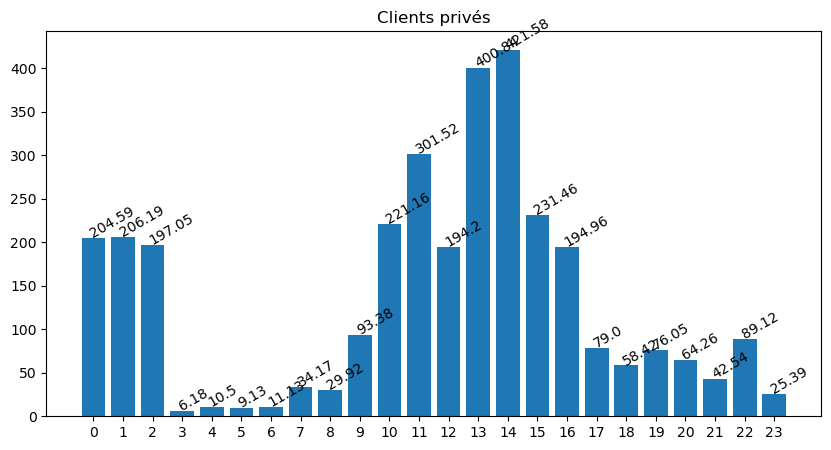

# Drummondville

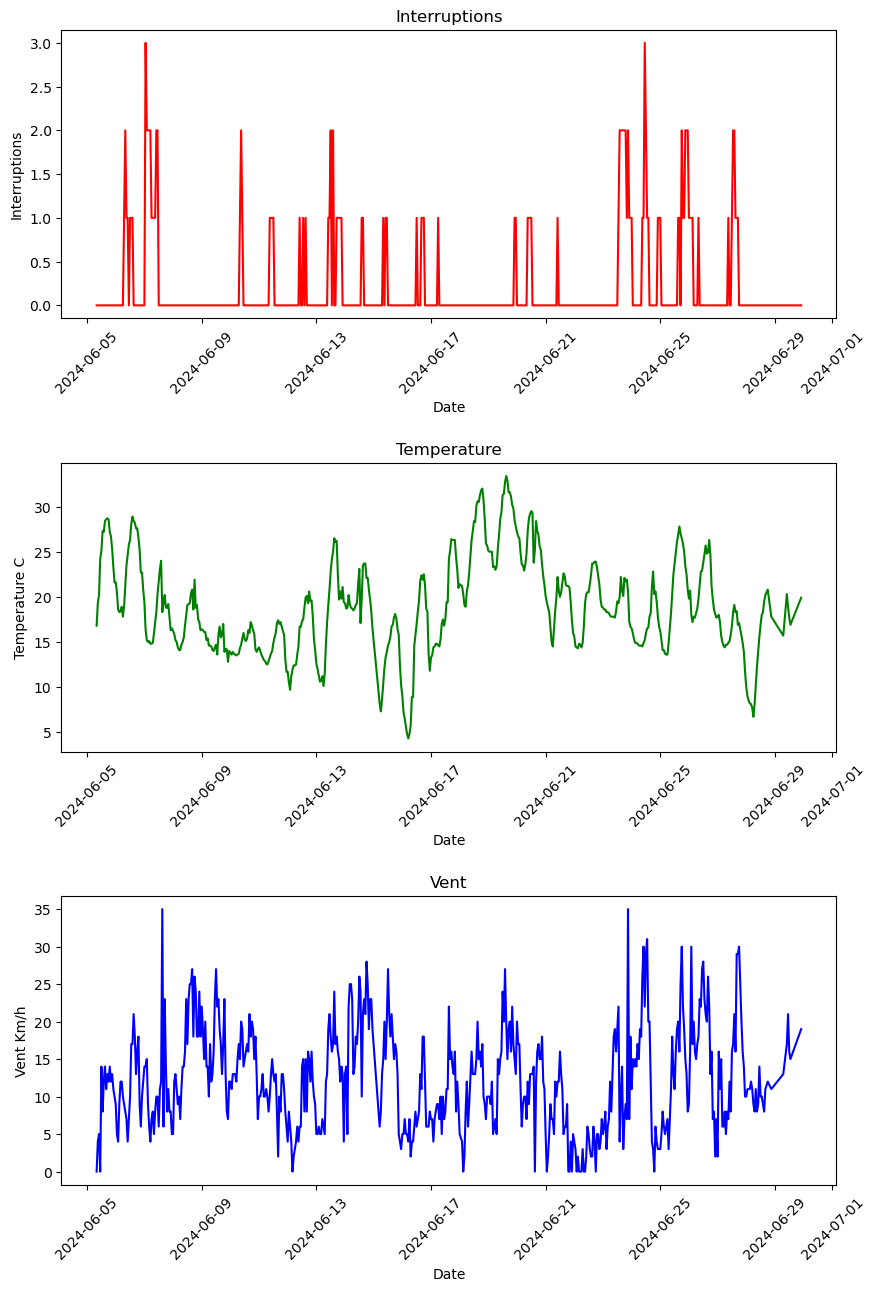

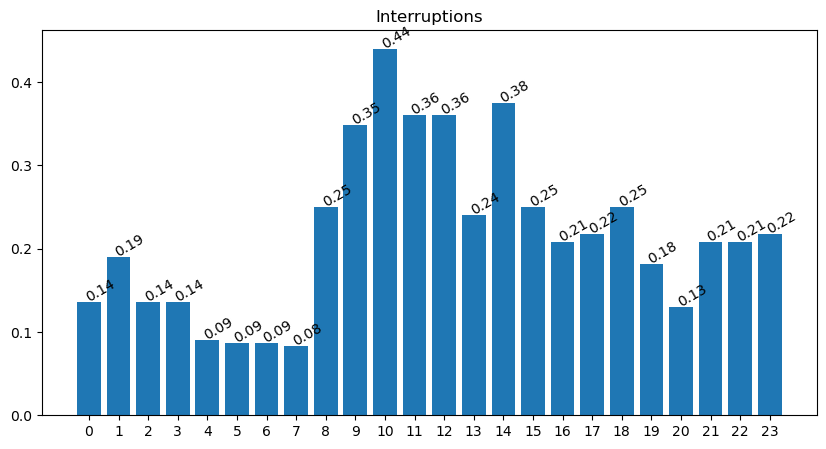

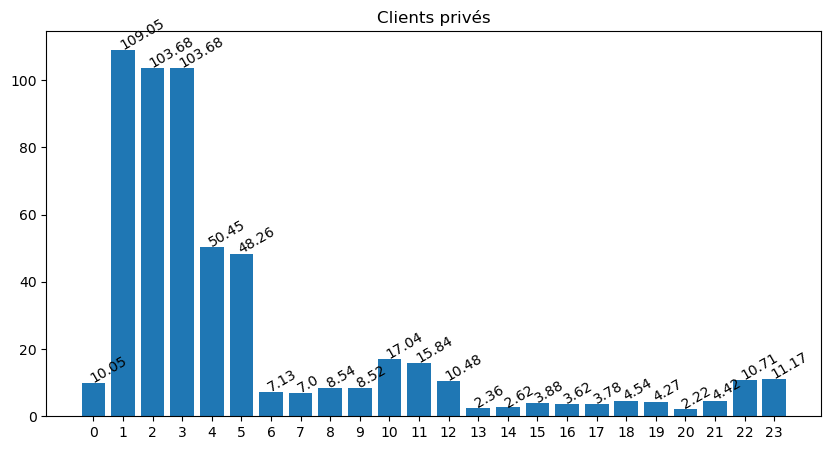

# Granby

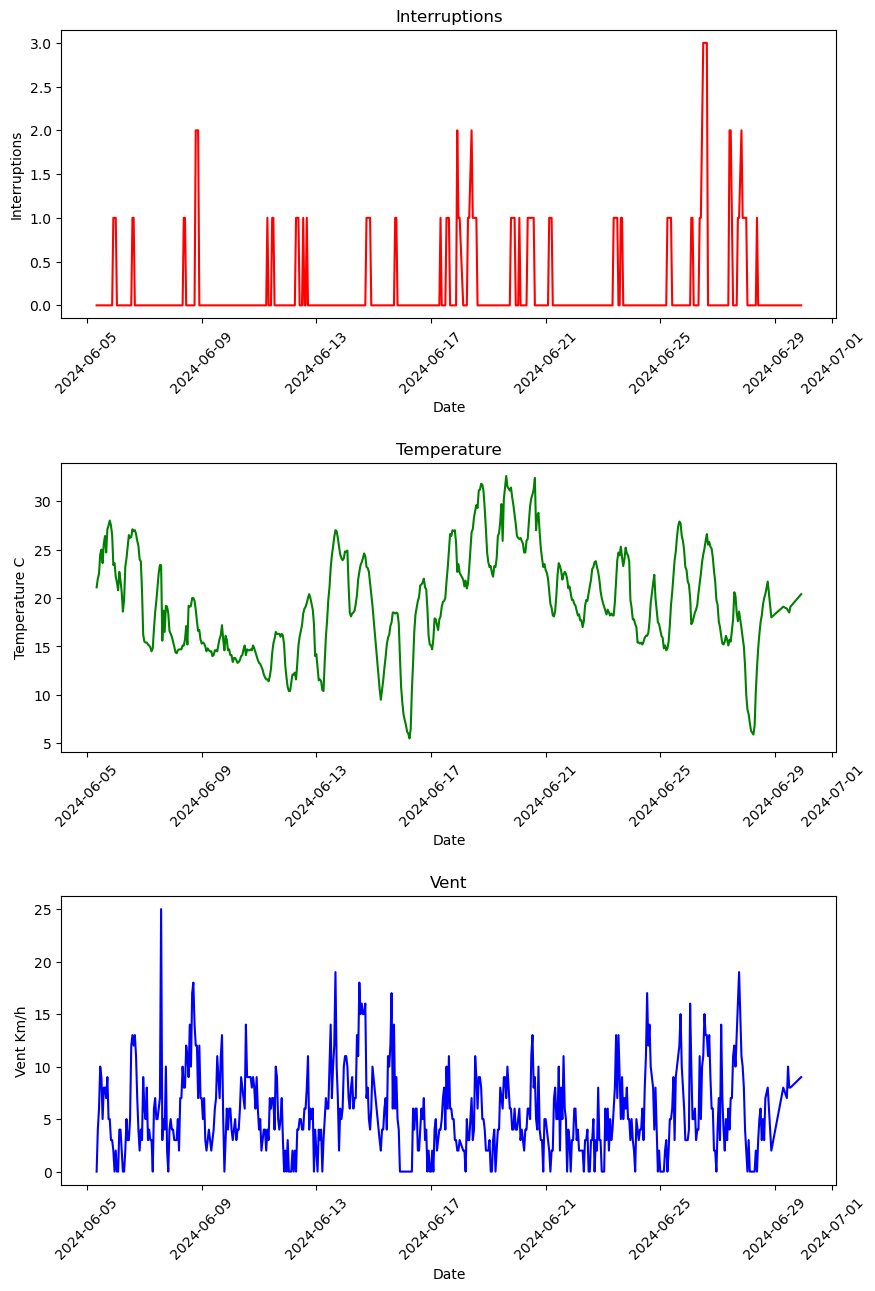

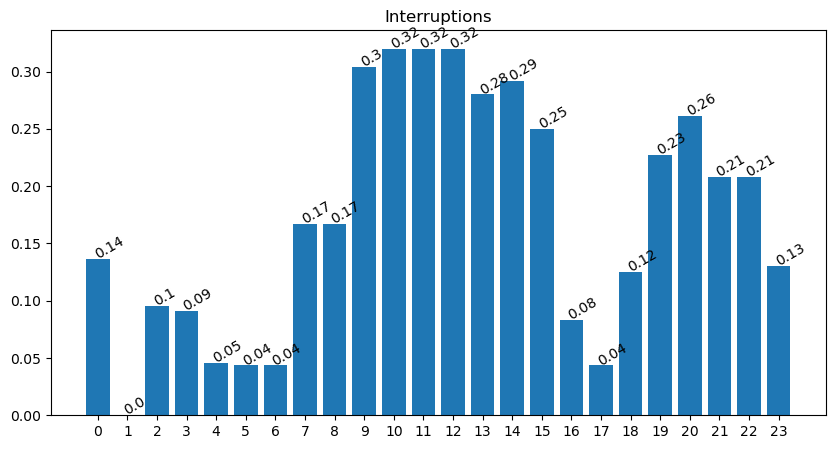

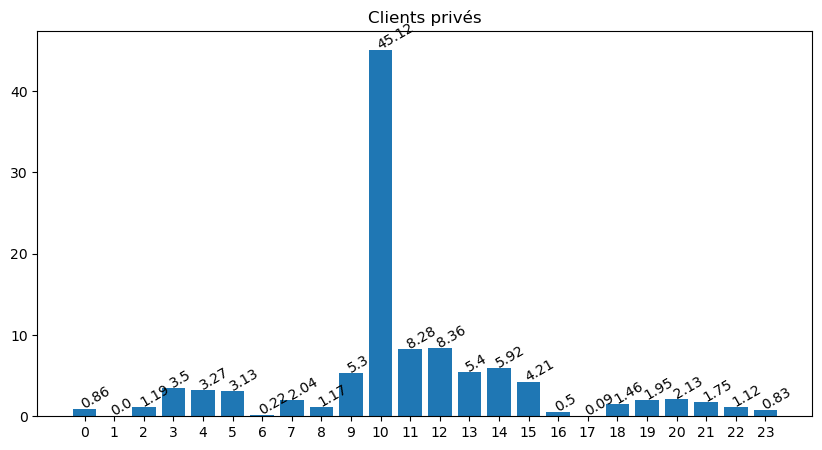

# Sherbrooke

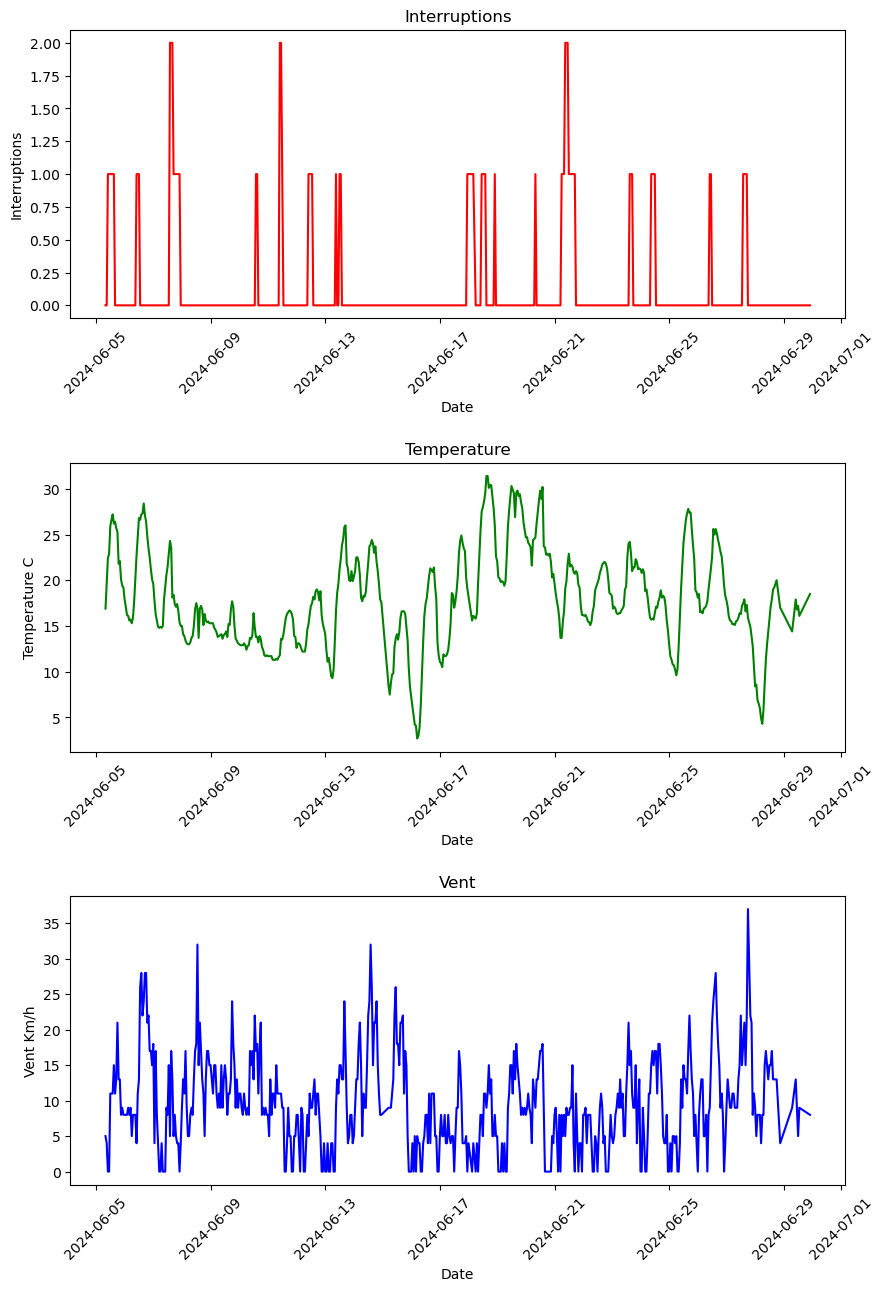

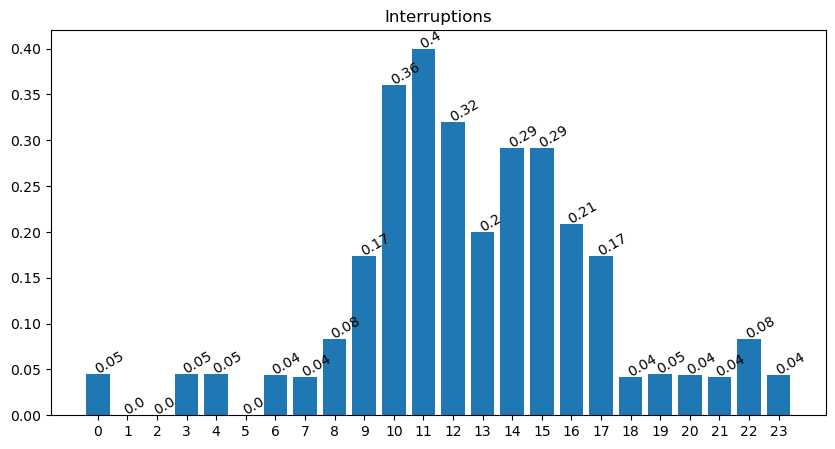

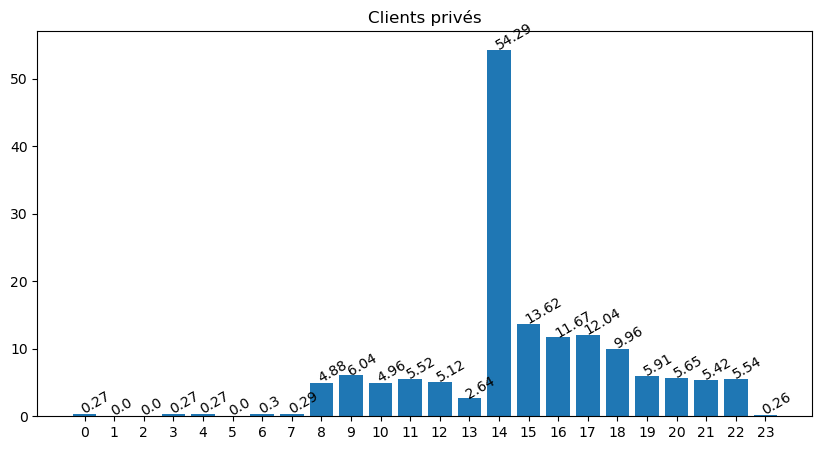

# Saint-Jérôme

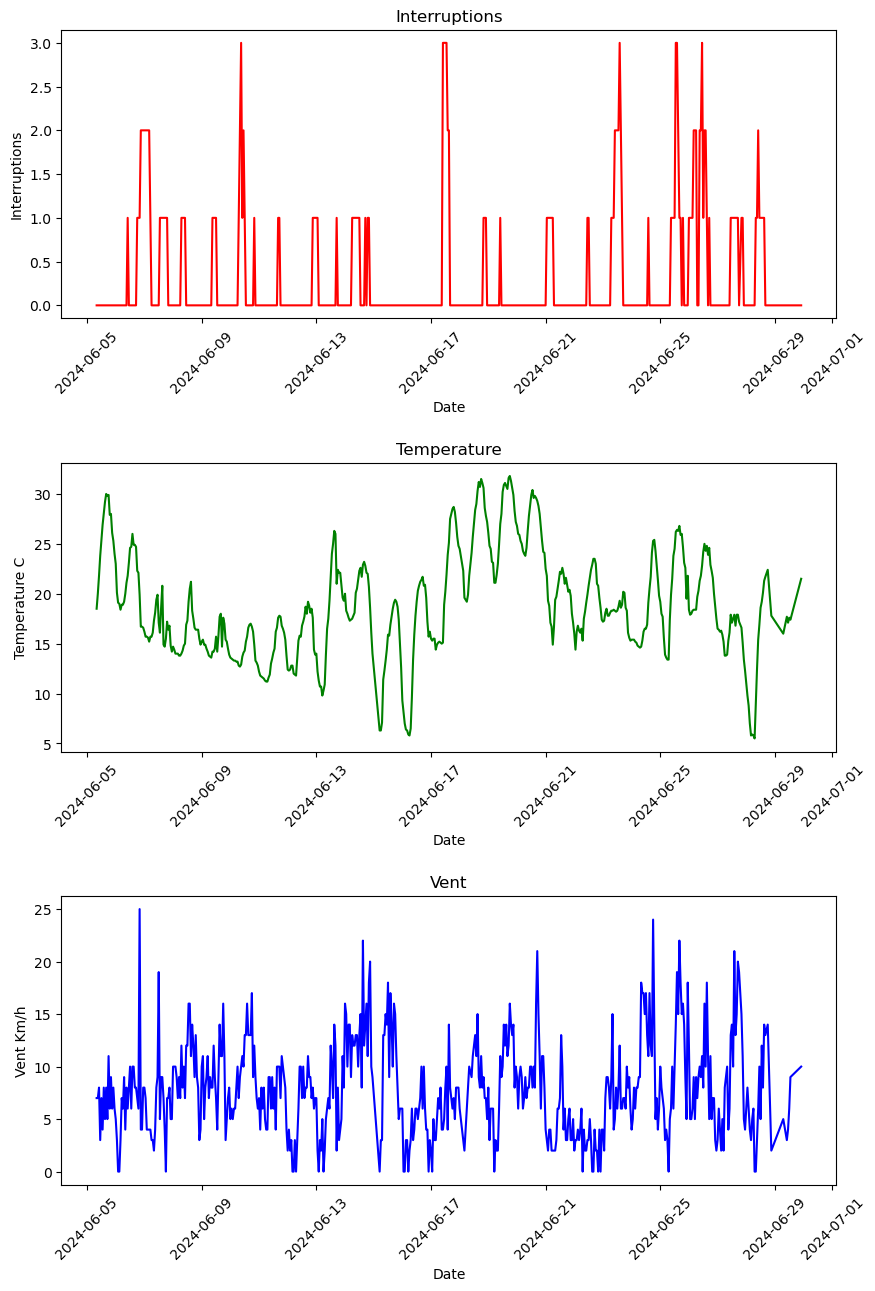

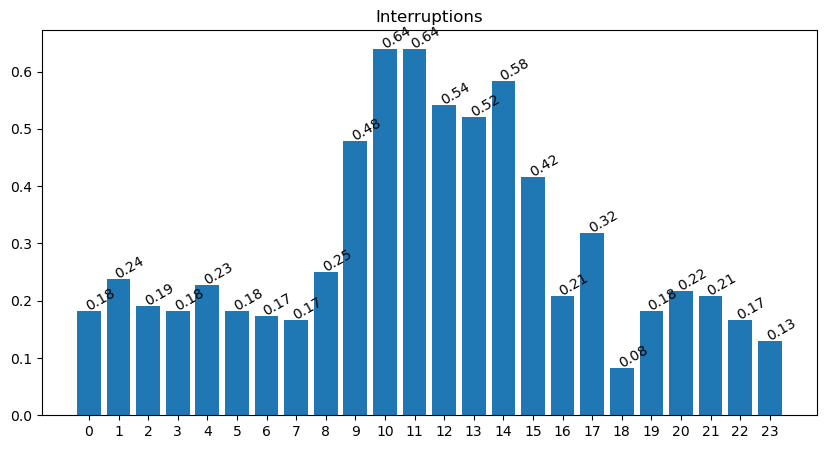

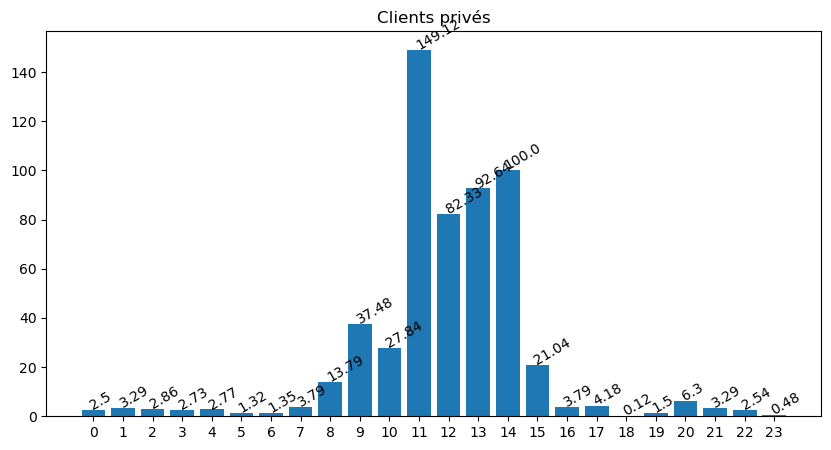

# Trois-Rivières

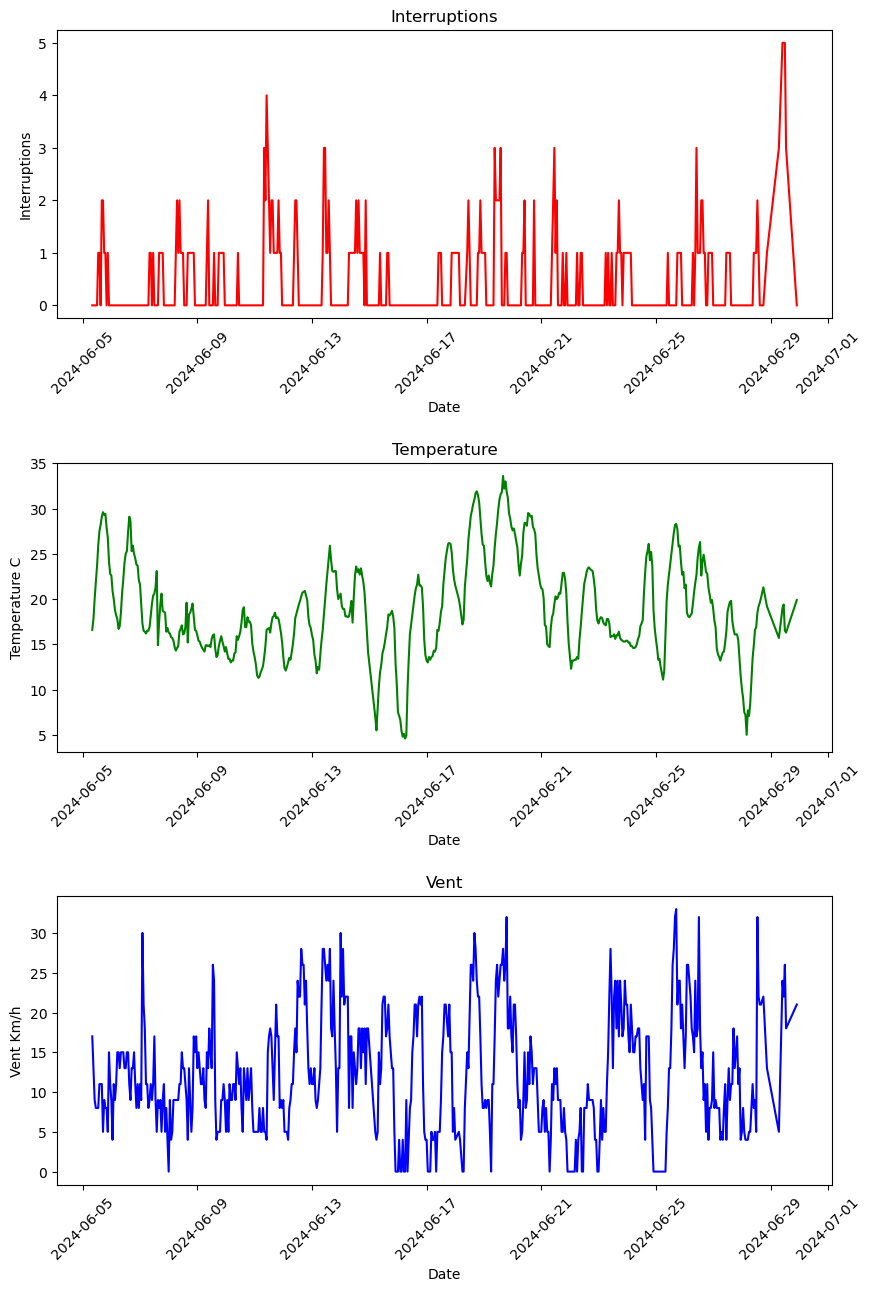

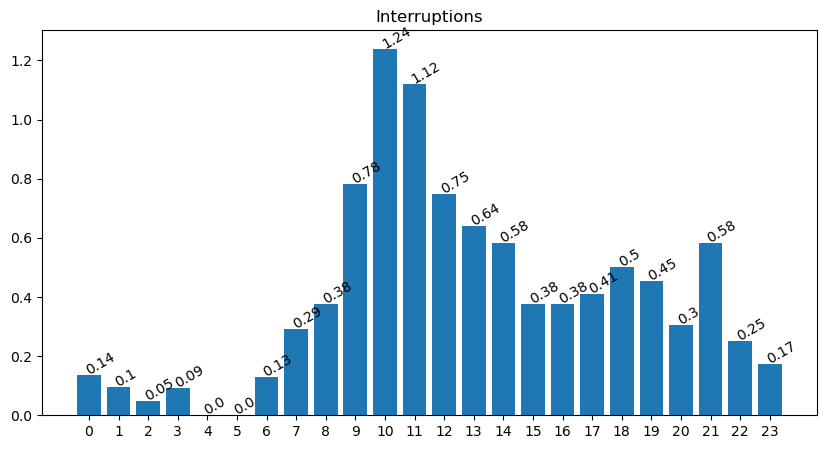

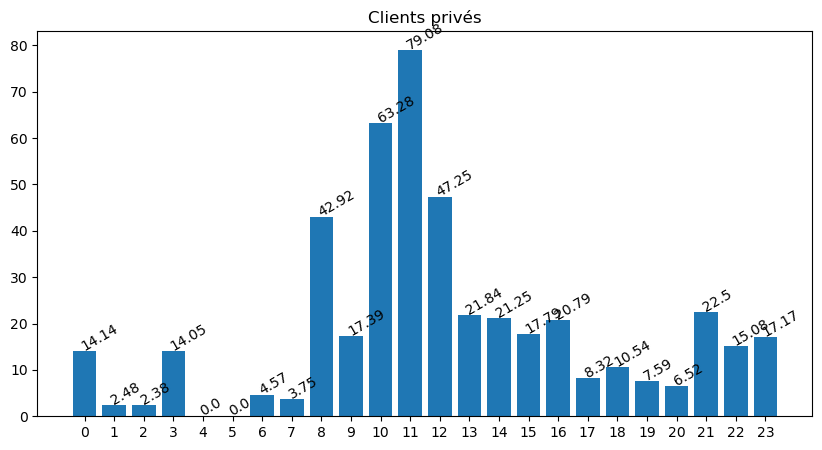

# Montréal

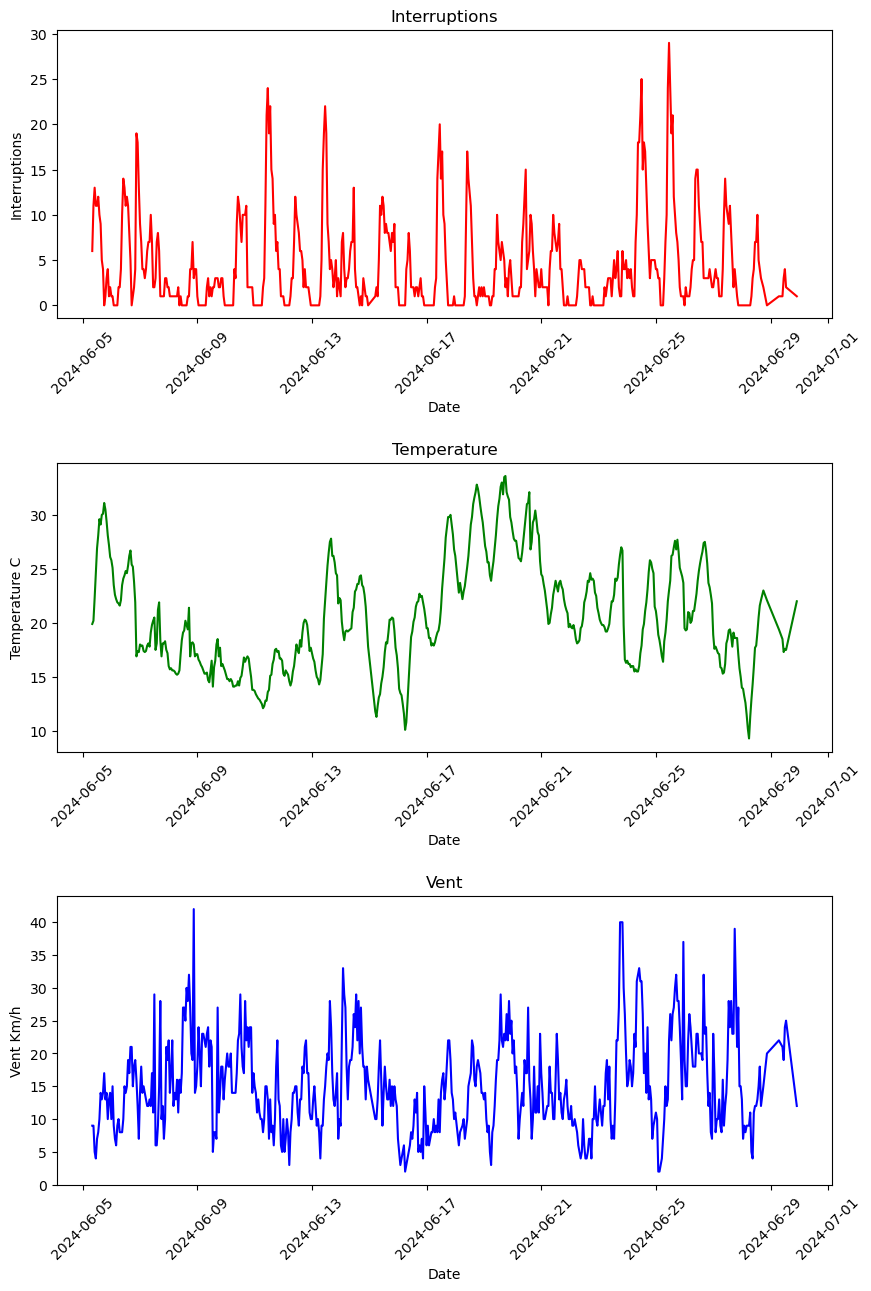

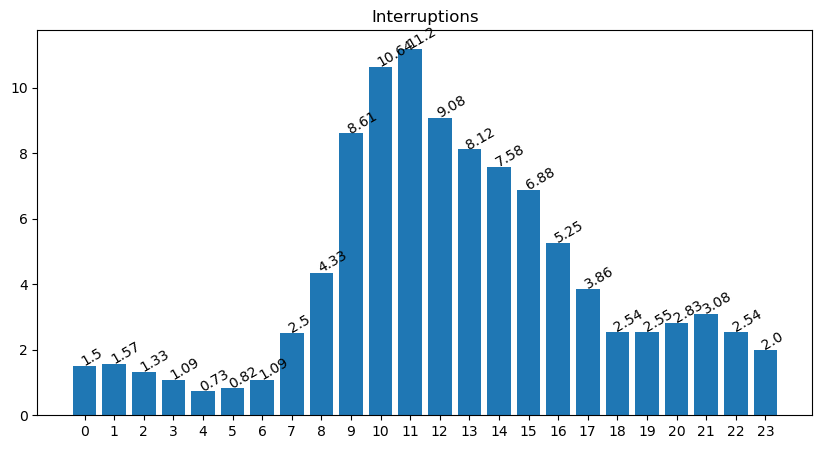

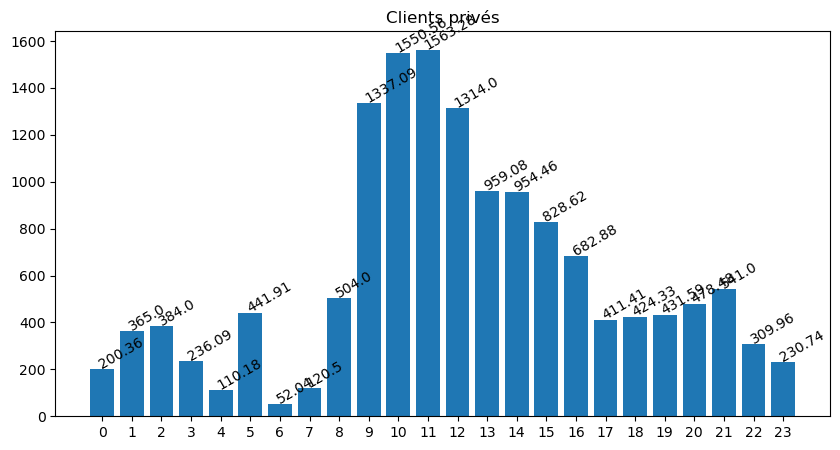

# Saint-Jean-sur-Richelieu

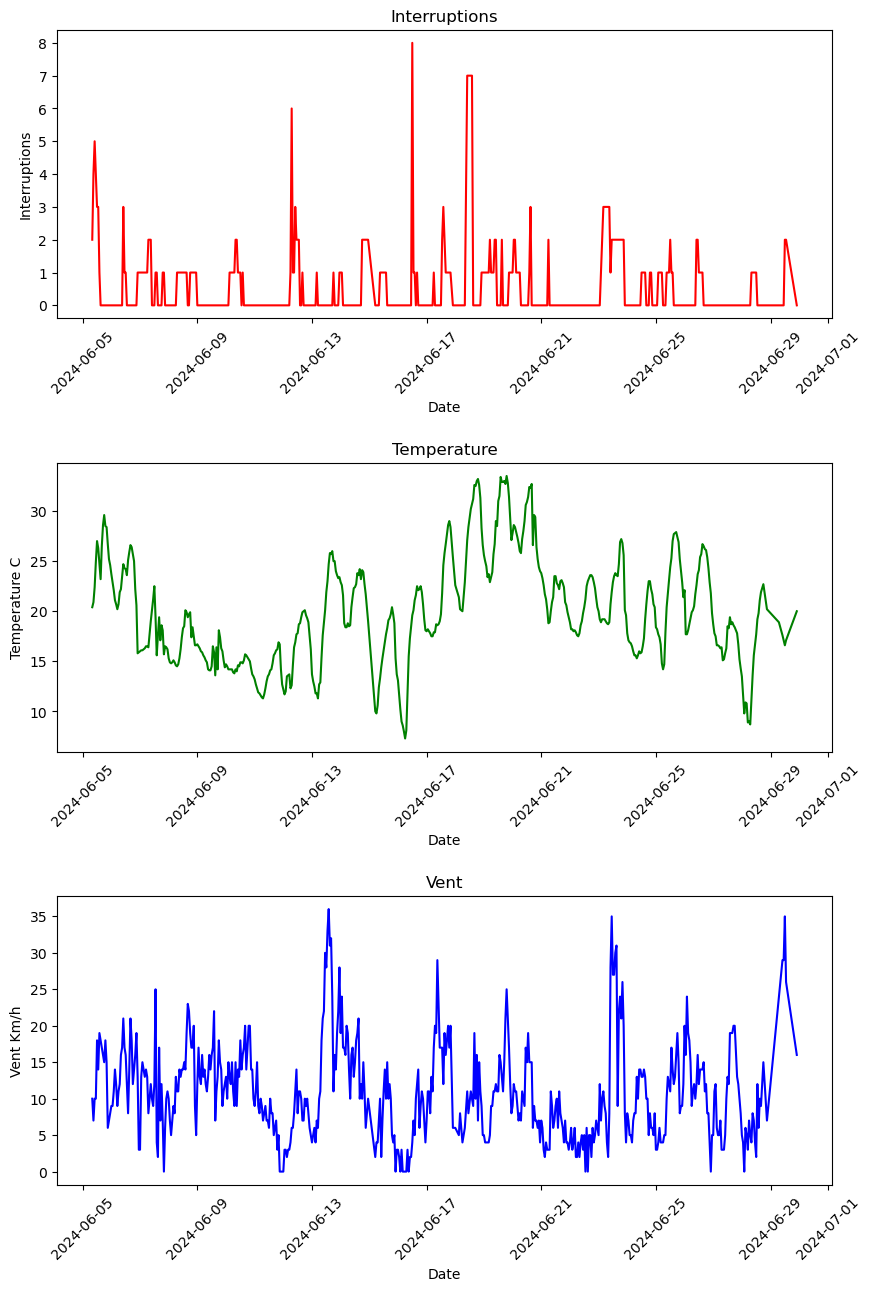

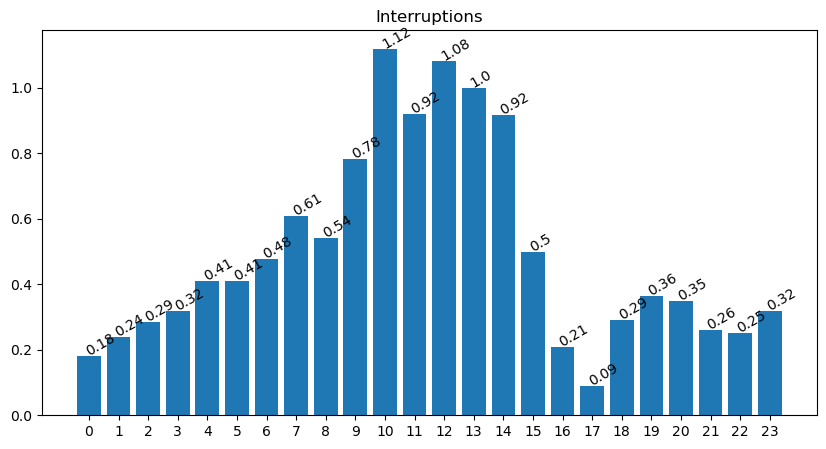

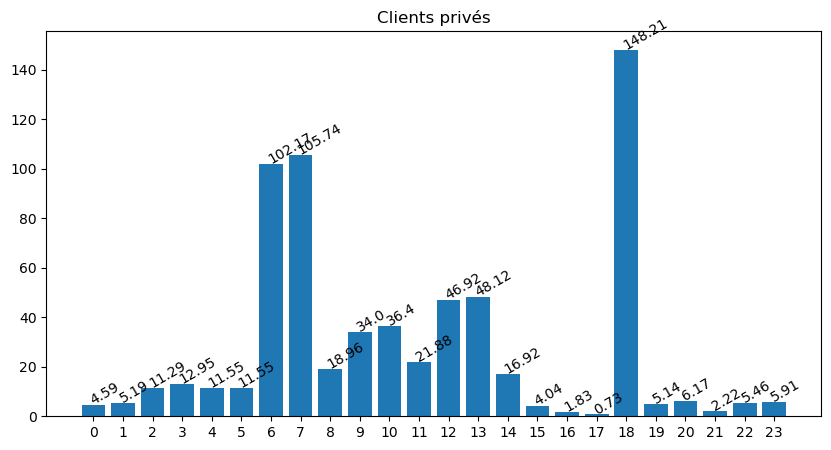

# Gatineau

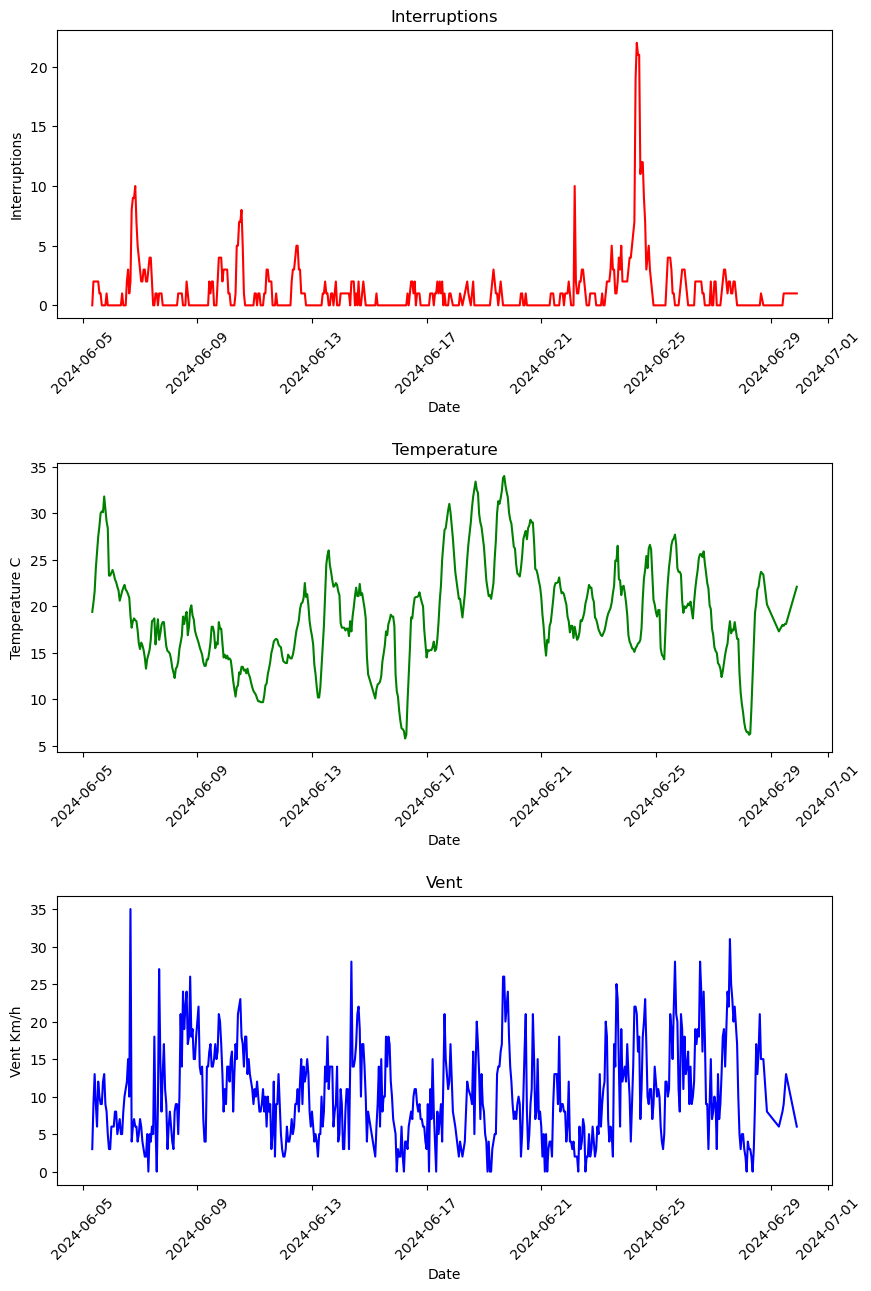

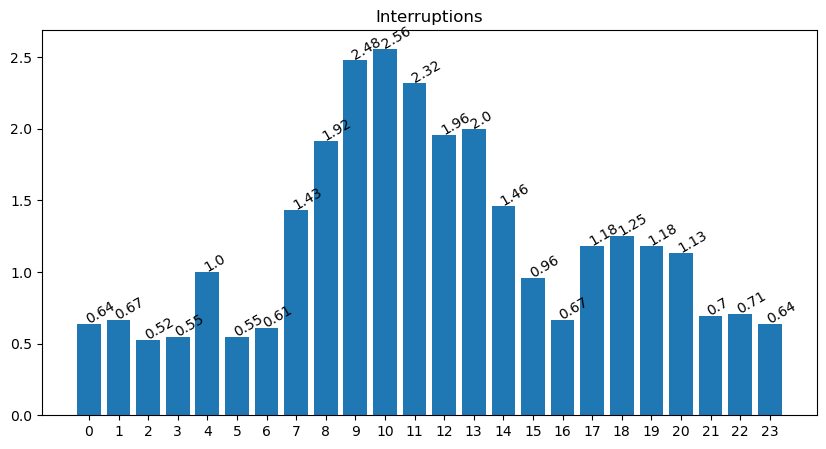

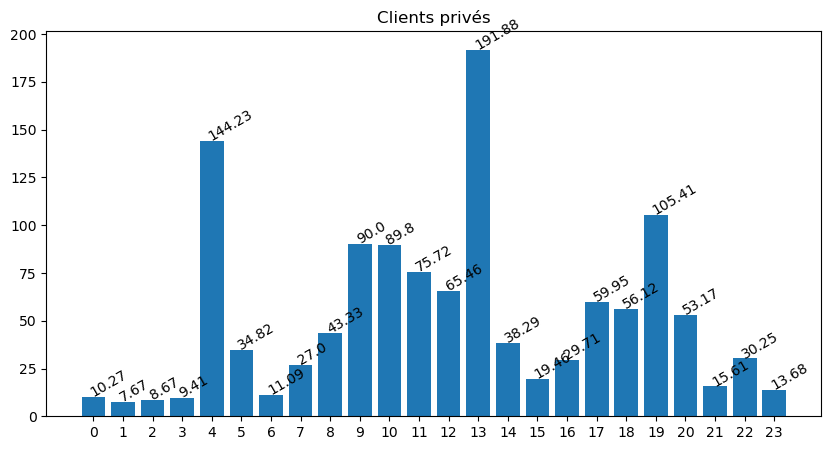

# Saguenay

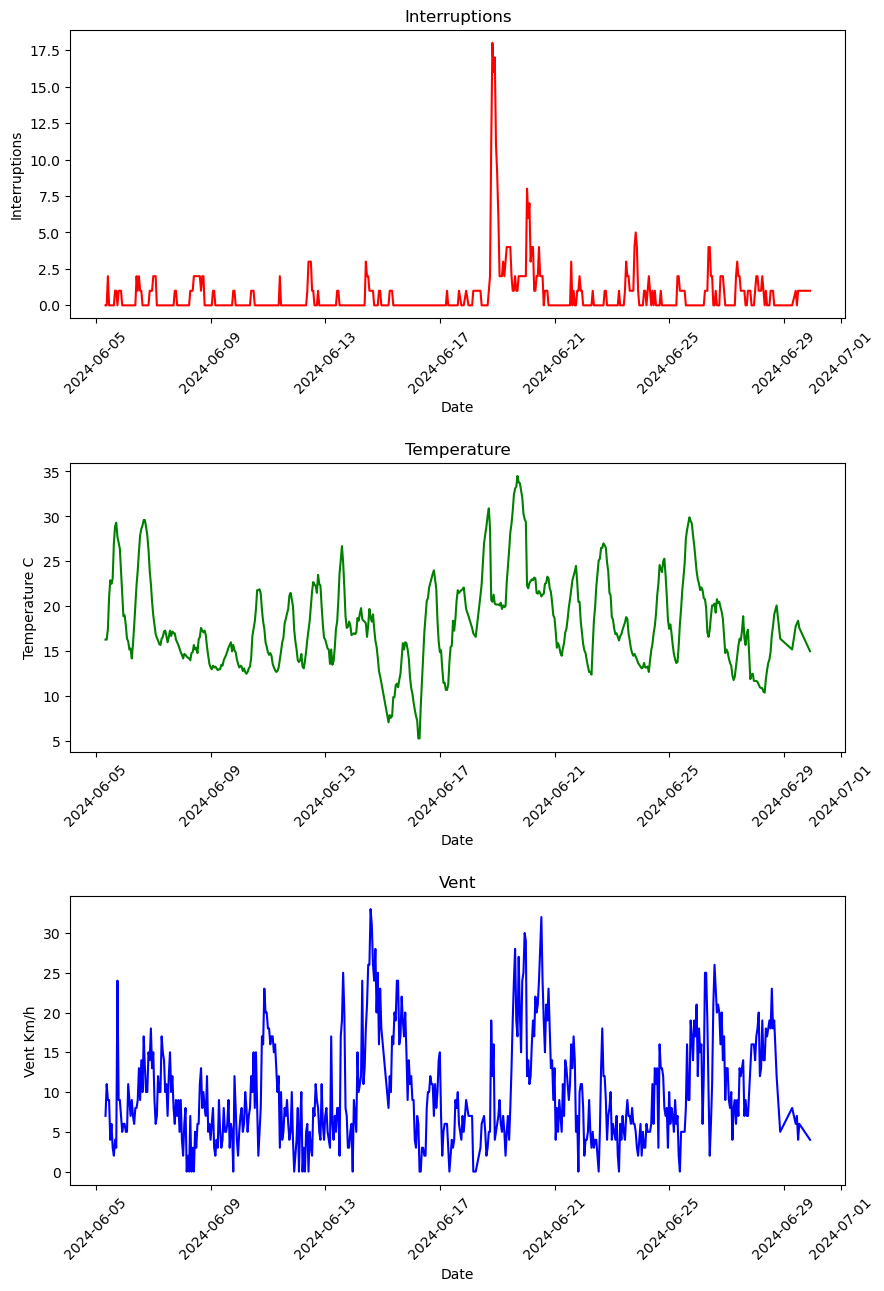

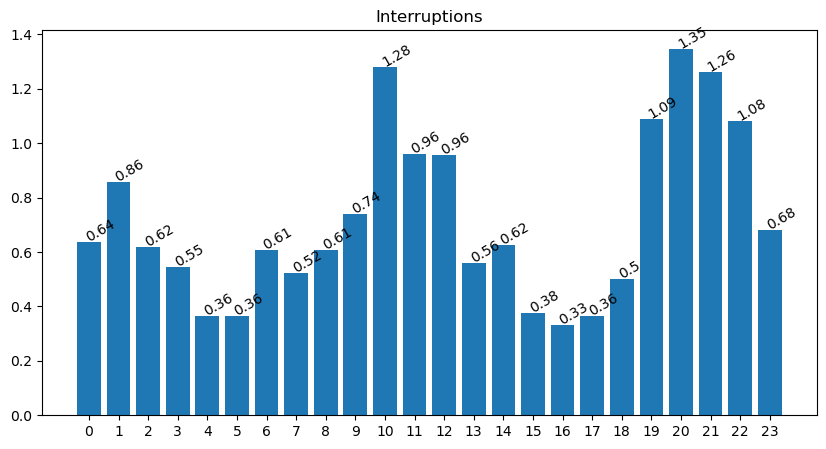

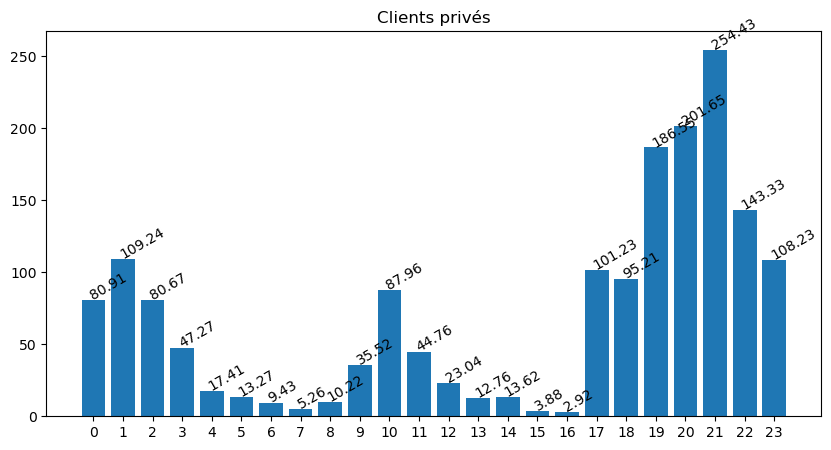

In [8]:
villes = df['region'].unique()

for ville in villes:
    graphs_par_ville(ville)

# Clients total

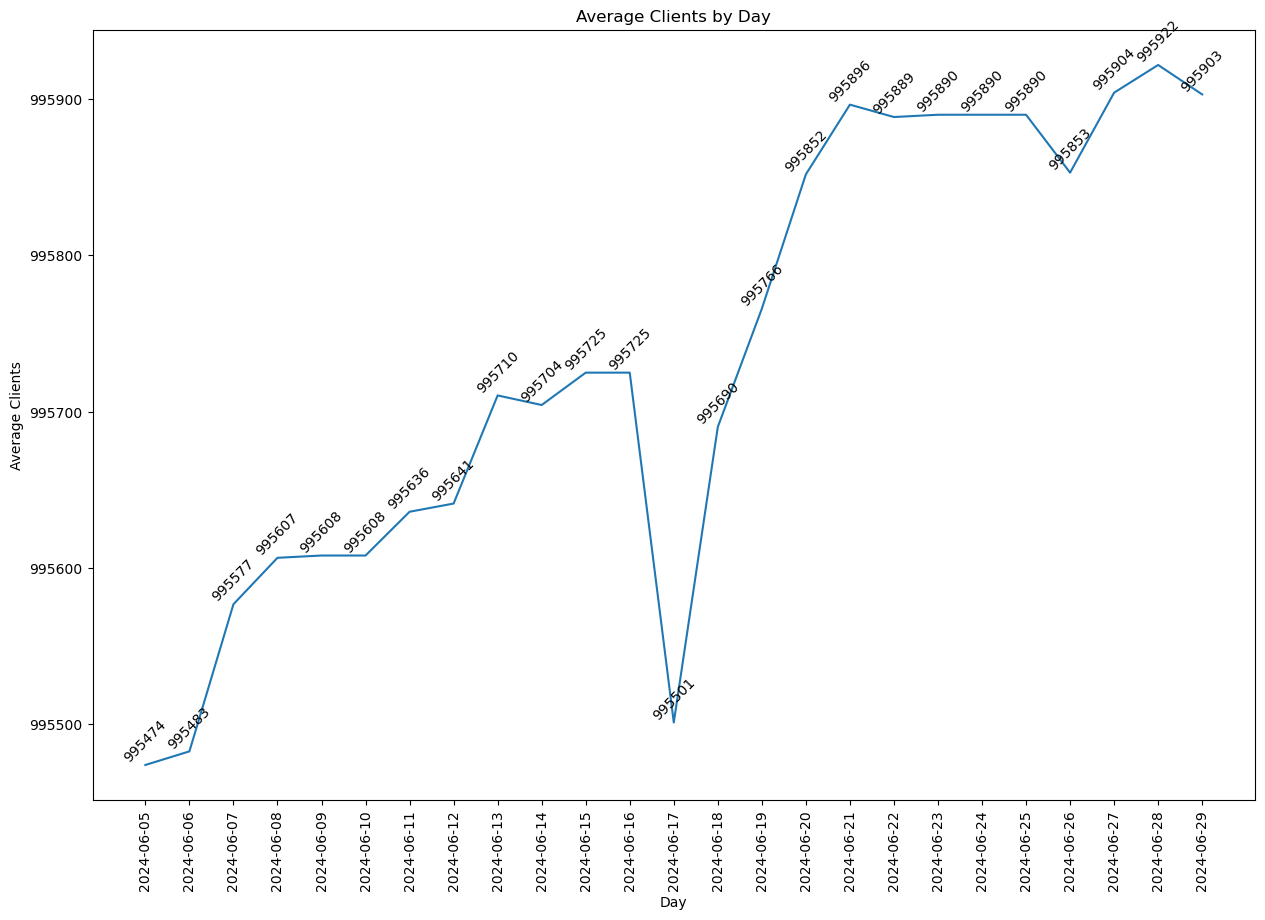

Max : 995926
Min : 995329
Max - min : 597


In [9]:
import matplotlib.pyplot as plt

ville = 'Montréal'
df_ville = df[df['region']==ville]

df_grouped = df.groupby(df_ville['date_heure'].dt.strftime('%Y-%m-%d'))['clients_total'].mean().reset_index()

plt.figure(figsize=(15, 10))
plt.plot(df_grouped['date_heure'], df_grouped['clients_total'])
# Add value labels to the plot
for i, val in enumerate(df_grouped['clients_total']):
    plt.text(i, val, str(round(val)), ha='center', va='bottom',rotation=45)
    
plt.xlabel('Day')
plt.ylabel('Average Clients')
plt.title('Average Clients by Day')
plt.xticks(rotation=90)
plt.show()

max = df_ville['clients_total'].max()
min = df_ville['clients_total'].min()
print("Max : {}".format(max))
print("Min : {}".format(min))
difference = df_ville['clients_total'].max() - df_ville['clients_total'].min()
print("Max - min : {}".format(difference))

# Pourcentage moyen de clients privés d'électricité

In [10]:

df['perc_clients_prive'] = (df['clients_prive'] / df['clients_total']) * 100
grouped_df = df.groupby('region')[['perc_clients_prive']].median().reset_index()

# New column name can be customized
grouped_df.rename(columns={'perc_clients_prive': 'clients_prive_percentage'}, inplace=True)

grouped_df


,region,clients_prive_percentage
0,Drummondville,0.000000
1,Gatineau,0.000000
2,Granby,0.000000
3,Montréal,0.014261
4,Québec,0.003415
5,Saguenay,0.000000
6,Saint-Jean-sur-Richelieu,0.000000
7,Saint-Jérôme,0.000000
8,Sherbrooke,0.000000
9,Trois-Rivières,0.000000
